# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# global imports
import os
from google.colab import drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import re
import nltk
import string

In [4]:
! pip install contractions
!pip install -U spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
import spacy
# import ktrain
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import re
from sklearn.feature_extraction.text import CountVectorizer
#from ktrain.text import StandardTextPreprocessor
import contractions
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
# getting stop_words from nltk and initializing a lemmatizer
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
from sklearn.cluster import KMeans
import time
import pickle
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize


# Data Cleaning

In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# import cupy as cp
import pandas as pd
import xml.etree.ElementTree as ET
from google.colab import drive
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [8]:
sentiment_words = [
    "couldn't", "shouldn't", "wasn't", "doesn't", "wouldn't",
    "nor", "won't", "mustn't", "isn't", "weren't", "haven't",
    "hadn't", "doesn't", "wasn't", "aren't", "hadn't", "shan't",
    "about", "don't", "shouldn't", "didn't", "wouldn't", "needn't",
    "mightn't", "haven't", "not", "no", "very"
]

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Remove sentiment affecting words
    for i in sentiment_words:
      if i in stop_words:
        stop_words.remove(i)

    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into string
    clean_text = ' '.join(filtered_tokens)

    return clean_text


def clean_aspect(aspect):
    # Convert to lowercase
    aspect = aspect.lower()

    # Remove punctuation
    aspect = aspect.translate(str.maketrans('', '', string.punctuation))

    return aspect

In [9]:
# load the dataset with labels

drive_path = '/content/drive/MyDrive/'
dataset_path = drive_path + 'Restaurants_Train_v2.xml'
dataset = []

f = ET.parse(dataset_path)
for i in f.getroot():
  for j in i.find("aspectCategories"):
    dataset.append({
        "input_text": clean_text(i.find("text").text),
        "aspect": clean_aspect(j.attrib['category']),
        "polarity": j.attrib['polarity']
    })

bgw_vectorizer = CountVectorizer(binary=False, stop_words='english', ngram_range=(1,4))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [10]:
df = pd.DataFrame(train_dataset)

In [11]:
df.head()

,input_text,aspect,polarity
0,decor nice casual fine dining,ambience,conflict
1,find returning quite often,anecdotesmiscellaneous,positive
2,seating trying get maximum amount people resta...,ambience,negative
3,like took leftover chicken poured oil sprinkle...,food,negative
4,finest latin women youll see life hang jimmys,ambience,positive


In [12]:
df['input_text'][4]

'finest latin women youll see life hang jimmys'

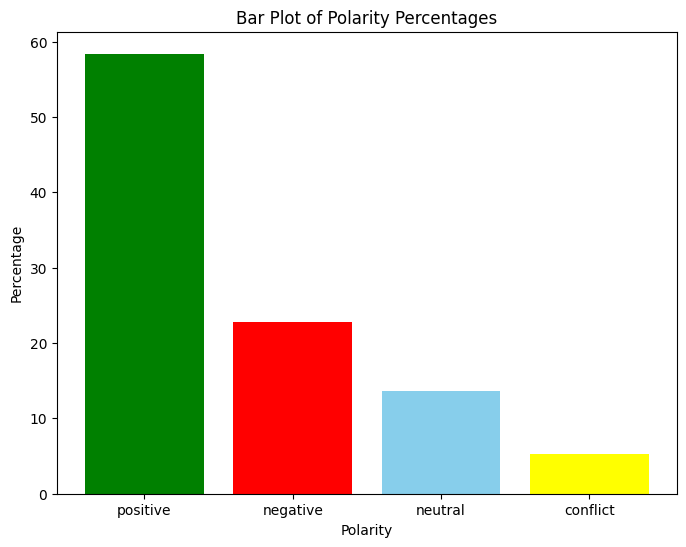

In [13]:
counts = df['polarity'].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
plt.figure(figsize=(8, 6))
plt.bar(percentages.index, percentages.values, color=["g", "r", "skyblue", "yellow"])
plt.xlabel('Polarity')
plt.ylabel('Percentage')
plt.title('Bar Plot of Polarity Percentages')

# Display the plot
plt.show()

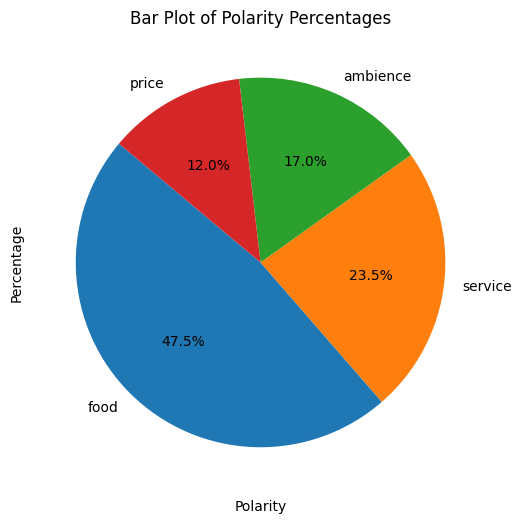

In [14]:
counts = df[df['aspect'] != "anecdotesmiscellaneous"]['aspect'].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
plt.xlabel('Polarity')
plt.ylabel('Percentage')
plt.title('Bar Plot of Polarity Percentages')

# Display the plot
plt.show()

# Getting aspect nouns



In [15]:
# Load spaCy model
nlp = spacy.load("en_core_web_lg")


# Define a function to extract nouns (aspects) from a review
def extract_nouns_from_review(review, nlp):
    # Process the review using spaCy pipeline
    doc = nlp(review)
    # Extract nouns from the review
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    return list(set(nouns))

# Extract nouns (aspects) for each review and add them as a new column to the DataFrame
df['extracted_nouns'] = df['input_text'].apply(lambda review: extract_nouns_from_review(review, nlp))

In [16]:
df.head()

,input_text,aspect,polarity,extracted_nouns
0,decor nice casual fine dining,ambience,conflict,"[decor, dining]"
1,find returning quite often,anecdotesmiscellaneous,positive,[]
2,seating trying get maximum amount people resta...,ambience,negative,"[neighbor, people, amount, seating]"
3,like took leftover chicken poured oil sprinkle...,food,negative,"[red, sauce, chicken, powder, pepper, oil]"
4,finest latin women youll see life hang jimmys,ambience,positive,"[life, women]"


In [17]:
df.shape

(2970, 4)

In [18]:
df = df[~(df['input_text']=='')] #removing blank reviews

In [19]:
df = df[df['input_text'].apply(lambda x: len(nltk.word_tokenize(x)))>1] #removing single worded reviews

In [20]:
df.shape

(2914, 4)

In [21]:
df.to_csv(drive_path+'semeval_cleaned.csv', index=False)

In [22]:
df=pd.read_csv(drive_path+'semeval_cleaned.csv')

In [23]:
df.shape

(2914, 4)

# Getting aspect categories

# BERT Topic Modelling

In [24]:
df=pd.read_csv(drive_path+'semeval_cleaned.csv')

import warnings
warnings.filterwarnings("ignore")

In [25]:
!pip install bertopic

In [26]:
%%time
from bertopic import BERTopic
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 4)
headline_topics, _ = model.fit_transform(df.input_text)

2024-04-21 18:40:40,864 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

2024-04-21 18:40:49,404 - BERTopic - Embedding - Completed ✓
2024-04-21 18:40:49,405 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-21 18:41:09,034 - BERTopic - Dimensionality - Completed ✓
2024-04-21 18:41:09,035 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-21 18:41:09,159 - BERTopic - Cluster - Completed ✓
2024-04-21 18:41:09,166 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-21 18:41:09,398 - BERTopic - Representation - Completed ✓


CPU times: user 43.5 s, sys: 1.84 s, total: 45.4 s
Wall time: 50.6 s


In [27]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 187


,Topic,Count,Name,Representation,Representative_Docs
0,-1,817,-1_table_italian_one_not,"[table, italian, one, not, restaurant, street,...",[italian food flavor sort surprising ues servi...
1,0,57,0_never_ive_times_disappointed,"[never, ive, times, disappointed, month, nigir...","[would never go back, ive never disappointed, ..."
2,1,37,1_waiter_waiters_two_containers,"[waiter, waiters, two, containers, nottryingto...",[waiter fine place looks nice nottryingtoohard...
3,2,35,2_bagels_bagel_cream_freeze,"[bagels, bagel, cream, freeze, spread, capex, ...","[good bagels good cream cheese, best bagels iv..."
4,3,33,3_puke_frequented_remains_walls,"[puke, frequented, remains, walls, ino, desire...",[puke green walls leave lot desired food very ...


In [28]:
model.visualize_barchart(top_n_topics=8)

In [29]:
model.visualize_topics()

In [30]:
model.visualize_hierarchy(top_n_topics=20)

We will take 4 main topics out of these clusters - food, service, ambience, price

# Using cosine similarity to get aspect of each review

In [31]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Load spaCy model with GloVe vectors
#!python -m spacy download en_core_web_lg #run this for every new session
nlp = spacy.load("en_core_web_lg")

# Define aspects and their corresponding words
aspects = {
    'food': 'food delicious tasty delicious flavor meal cuisine chef portion seasoned authentic',
    'service': 'service staff friendly helpful attentive prompt',
    'ambience': 'ambience ambiance atmosphere decor decoration cozy elegant modern chic view clean dirty dusty',
    'price': 'price value affordable expensive budget cost cheap',
    # 'anecdotesmiscellaneous': 'location parking cleanliness presentation variety'

}


# Define a function to compute aspect embeddings
def compute_aspect_embeddings(aspects, nlp):
    aspect_embeddings = {}
    for aspect, words in aspects.items():
        # Tokenize and average the word vectors for each aspect
        tokens = nlp(words)
        aspect_vectors = [token.vector for token in tokens if token.has_vector]
        aspect_embeddings[aspect] = np.mean(aspect_vectors, axis=0)
    return aspect_embeddings

# Define a function to compute review embeddings
def compute_review_embedding(review, nlp):
    # Process the review using spaCy pipeline
    doc = nlp(review)
    sentence_embeddings = []
    for sent in doc.sents:
        # Compute sentence embedding by averaging word vectors
        sent_vector = np.mean([word.vector for word in sent if word.has_vector], axis=0)
        sentence_embeddings.append(sent_vector)
    # Replace new words with zeros and compute review embedding
    review_embedding = np.mean(sentence_embeddings, axis=0)
    return np.nan_to_num(review_embedding)


def compute_sentence_embedding(sentence, nlp):
    # Process the sentence using spaCy pipeline
    doc = nlp(sentence)
    # Compute sentence embedding by averaging word vectors
    sent_vector = np.mean([word.vector for word in doc if word.has_vector], axis=0)
    # Replace NaN values with zeros
    return np.nan_to_num(sent_vector)


# Compute semantic similarity between review sentences and aspect embeddings
def compute_semantic_similarity(review_sentences, aspect_embeddings):
    aspect_names = list(aspect_embeddings.keys())
    similarity_scores = []
    for sentence in review_sentences:
        sentence_vector = compute_review_embedding(sentence, nlp)
        sentence_vector = sentence_vector.reshape(1, -1)  # Reshape to match cosine_similarity function input
        sentence_similarity = []
        for aspect_name, aspect_vector in aspect_embeddings.items():
            aspect_vector = aspect_vector.reshape(1, -1)  # Reshape to match cosine_similarity function input
            similarity = cosine_similarity(sentence_vector, aspect_vector)[0][0]
            sentence_similarity.append(similarity)
        similarity_scores.append({aspect_name: score for aspect_name, score in zip(aspect_names, sentence_similarity)})
    return similarity_scores

In [32]:
# review_sentences = df['input_text'][0:100].to_list() --working fine

# review_sentences = df['input_text']

review_sentences = df['input_text']

#for each review in 'cleaned_text' and get a list of aspects

# Compute aspect embeddings
aspect_embeddings = compute_aspect_embeddings(aspects, nlp)

# Compute semantic similarity
semantic_similarity_scores = compute_semantic_similarity(review_sentences, aspect_embeddings)

# Choose the aspect with the highest similarity score for each sentence
chosen_aspects = [max(scores, key=scores.get) for scores in semantic_similarity_scores]

In [33]:
# Output the chosen aspects for each sentence
for sentence, aspect in zip(review_sentences, chosen_aspects):
    print("Sentence:", sentence)
    print("Chosen Aspect:", aspect)
    print()

Streaming output truncated to the last 5000 lines.
Chosen Aspect: food

Sentence: not imagine not rushing eat
Chosen Aspect: food

Sentence: die hard peep lover
Chosen Aspect: ambience

Sentence: live neightborhood regular
Chosen Aspect: service

Sentence: id definitely recommend little place
Chosen Aspect: ambience

Sentence: recommend getting reservation even though saw people seated without one
Chosen Aspect: service

Sentence: tried various slice joints around village far best one
Chosen Aspect: service

Sentence: ive twice
Chosen Aspect: food

Sentence: keep fingers crossed whole subway ride hoping table sit not share rice congee soup people
Chosen Aspect: food

Sentence: glass leaping lizard glass prosecco mussels everything happy
Chosen Aspect: ambience

Sentence: decor nice minimalist food simple yet very well presented cooked wine list matches food very well
Chosen Aspect: food

Sentence: appetizers ate dim sum variety foods impossible criticize food
Chosen Aspect: food

Sente

In [34]:
df['aspect_predicted'] = chosen_aspects

In [35]:
df.head()

,input_text,aspect,polarity,extracted_nouns,aspect_predicted
0,decor nice casual fine dining,ambience,conflict,"['decor', 'dining']",ambience
1,find returning quite often,anecdotesmiscellaneous,positive,[],service
2,seating trying get maximum amount people resta...,ambience,negative,"['neighbor', 'people', 'amount', 'seating']",service
3,like took leftover chicken poured oil sprinkle...,food,negative,"['red', 'sauce', 'chicken', 'powder', 'pepper'...",food
4,finest latin women youll see life hang jimmys,ambience,positive,"['life', 'women']",ambience


# Accuracy check

In [36]:
df2 = df[df['aspect'] != "anecdotesmiscellaneous"]

In [37]:
cnt = (df2['aspect'] == df2['aspect_predicted']).sum()

In [38]:
cnt

1304

In [39]:
df2.shape

(2035, 5)

In [40]:
print("Accuracy: ", cnt / len(df2))

Accuracy:  0.6407862407862408


# 65% accuracy

# Anurag's Changes

In [41]:
import ngram_nb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
train_idx = int(.8*len(df2))
model = ngram_nb.Ngram_NB(1)

shuffled_df = df2.sample(frac=1)
df_train = shuffled_df[:train_idx]
df_test = shuffled_df[train_idx:]
model.train(df_train, text_col = "input_text", category_col = "aspect")

df_polarity_predictions = []
for category in df_test["aspect"].unique():
    df_test_category = df_test[df_test["aspect"] == category]
    y_pred = df_test_category["input_text"].apply(lambda x: model.score(x, category = category)[0])
    y_true = df_test_category["polarity"]
    print(category, accuracy_score(y_true, y_pred))
    conf_mat = confusion_matrix(y_true, y_pred, labels = y_true.unique())
    print(y_true.unique())
    print(conf_mat)
    df_test_category["polarity_pred"] = y_pred
    df_polarity_predictions.append(df_test_category)

df_test_category
pd.concat(df_polarity_predictions).reset_index().to_csv("ngram_nb_predictions_df.csv")

food 0.7040816326530612
['positive' 'neutral' 'negative' 'conflict']
[[131   0   5   0]
 [ 10   1   0   0]
 [ 26   2   6   0]
 [ 13   0   2   0]]
service 0.7575757575757576
['positive' 'conflict' 'negative' 'neutral']
[[46  0  7  0]
 [ 3  0  1  0]
 [11  0 29  0]
 [ 1  0  1  0]]
ambience 0.7611940298507462
['positive' 'negative' 'conflict' 'neutral']
[[44  1  0  0]
 [ 8  6  0  0]
 [ 1  4  1  0]
 [ 2  0  0  0]]
price 0.6888888888888889
['negative' 'positive' 'conflict' 'neutral']
[[13  6  0  0]
 [ 5 18  0  0]
 [ 1  1  0  0]
 [ 0  1  0  0]]


# Fabian's Changes

In [43]:
# Bi-Directional Lstm with Attention Mechanism.

%load_ext autoreload
%autoreload 2

from models import bilstm_withattention

absa = bilstm_withattention.AspectBasedSentimentAnalysis()
absa.train(df2)

pd_test = pd.DataFrame(test_dataset)
df_test, loss, accuracy = absa.test(pd_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
print(df_test.head())
df_test.to_csv("./bilstm_withattention_res.csv", encoding='utf-8')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2Vec model trained and saved.
Epoch 1/20
51/51 [==============================] - 5s 33ms/step - loss: 1.0138 - accuracy: 0.6167 - val_loss: 1.0023 - val_accuracy: 0.6158
Epoch 2/20
51/51 [==============================] - 1s 11ms/step - loss: 0.9968 - accuracy: 0.6278 - val_loss: 1.0057 - val_accuracy: 0.6158
Epoch 3/20
51/51 [==============================] - 0s 9ms/step - loss: 0.9903 - accuracy: 0.6290 - val_loss: 1.0004 - val_accuracy: 0.6158
Epoch 4/20
51/51 [==============================] - 0s 7ms/step - loss: 0.9887 - accuracy: 0.6290 - val_loss: 1.0002 - val_accuracy: 0.6158
Epoch 5/20
51/51 [==============================] - 0s 7ms/step - loss: 0.9928 - accuracy: 0.6290 - val_loss: 1.0028 - val_accuracy: 0.6158
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 0.9807 - accuracy: 0.6290 - val_loss: 0.9998 - val_accuracy: 0.6158
Epoch 7/20
51/51 [==============================] - 0s 7ms/step - loss: 0.9822 - accuracy: 0.6290 - val_loss: 0.9985 - val_a

KeyError: "Key 'steakhouse' not present"

In [ ]:
# ATAE-LSTM

%load_ext autoreload
%autoreload 2

from models import lstm_atae

absa = lstm_atae.AspectBasedSentimentAnalysis()
absa.train(df2)

pd_test = pd.DataFrame(test_dataset)
df_test, loss, accuracy = absa.test(pd_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
print(df_test.head())
df_test.to_csv("./lstm_atae_res.csv", encoding='utf-8')

# Logistic Regression

In [ ]:
%load_ext autoreload
%autoreload 2

from models import logistic

logi = logistic.Logistic()
tr = pd.DataFrame(train_dataset)
logi.train(df2)
out, report = logi.test(test_dataset)
print(report)
out.to_csv("./logistic_res.csv", encoding='utf-8')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
              precision    recall  f1-score   support

           0       0.54      0.47      0.50       163
           1       0.69      0.93      0.80       445
           2       0.50      0.01      0.02        97
           3       0.00      0.00      0.00        38

    accuracy                           0.66       743
   macro avg       0.43      0.35      0.33       743
weighted avg       0.60      0.66      0.59       743



# BERT UnCased

In [ ]:
%load_ext autoreload
%autoreload 2

from models import bert_uncased

bert_uncase = bert_uncased.BERTUncased(15)
bert_uncase.train(df2)
out, report = bert_uncase.test(test_dataset)
print(report)
out.to_csv("./bert_base_res.csv", encoding='utf-8')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Epoch 1
Loss:  0.9274495002870359
Starting Epoch 2
Loss:  0.7722076520777521
Starting Epoch 3
Loss:  0.6246266502938242
Starting Epoch 4
Loss:  0.49019280180137437
Starting Epoch 5
Loss:  0.38709108099571937
                                            input_text  \
0    forget rush wait noise isnt actually bad mean ...   
1        type place run old friends late raucus dinner   
2                                  dont look nose like   
3                 tuk tuk one rare choices go brooklyn   
4                great food great prices great service   
..                                                 ...   
738  like music blasted system isnt great want pay ...   
739           food always tastes fresh served promptly   
740  good atmosphere combination hottest music dres...   
741  looking around saw room full new yorkers enjoy...   
742                         importantly food excellent   

                     aspect  polarity  y_pred  
0                  ambience  conflict 

In [ ]:
# Common cell to comapre and contrast varoius above models

In [ ]:
# Load and test a few sentences from the YELP dataset